In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

from unsloth import FastLanguageModel
from transformers import TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset
from trl import SFTTrainer
import torch, matplotlib.pyplot as plt

In [ ]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-bnb-4bit", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

In [ ]:
special_tokens = ["<|startofchat|>", "<|turn|>"]
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
model.resize_token_embeddings(len(tokenizer))

Embedding(128258, 2048, padding_idx=128004)

In [ ]:
dataset = load_dataset("json", data_files="synthetic_daily_chat.jsonl", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 600,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/569 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

Step,Training Loss
1,6.385000
2,6.375100
3,6.068700
4,6.053100
5,6.068700
6,5.998400
7,5.413000
8,5.196700
9,5.278800
10,5.036000


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [ ]:
# Perplexity and Loss on Eval Dataset
import math
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling

# ✅ Load raw eval set (same format as train)
raw_eval_dataset = load_dataset("json", data_files="eval_dataset.jsonl", split="train")

# ✅ Tokenize the eval dataset to get input_ids
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=2048)

eval_dataset = raw_eval_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# ✅ Set up proper collator
trainer.data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
trainer.args.remove_unused_columns = False

# ✅ Run evaluation
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
eval_loss = eval_results["eval_loss"]
perplexity = math.exp(eval_loss)

print(f"🧠 Eval Loss: {eval_loss:.4f}")
print(f"📉 Perplexity: {perplexity:.2f}")


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

🧠 Eval Loss: 5.4463
📉 Perplexity: 231.89


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
12.568 GB of memory reserved.


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

499.777 seconds used for training.
8.33 minutes used for training.
Peak reserved memory = 12.568 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 56.712 %.
Peak reserved memory for training % of max memory = 0.0 %.


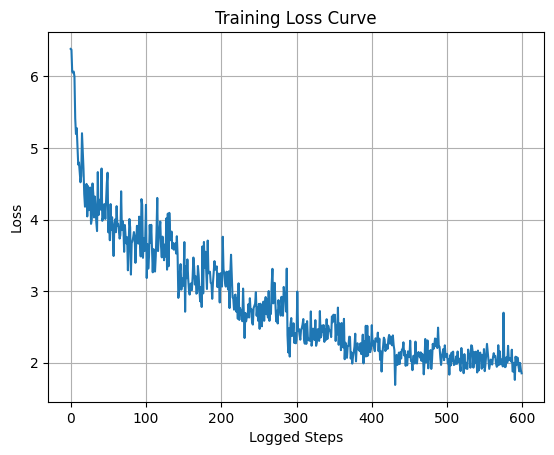

In [ ]:
import matplotlib.pyplot as plt

# Extract training loss from logs
logs = trainer.state.log_history
losses = [log["loss"] for log in logs if "loss" in log]

# Plot training loss
plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Logged Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")

In [ ]:
model.push_to_hub_gguf("fazmain/swiftcompose-llama-1b", tokenizer, quantization_method = "q4_k_m", token = "personal_access_token")

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 36.52 out of 52.96 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 16/16 [00:00<00:00, 51.70it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at fazmain/swiftcompose-llama-1b into bf16 GGUF format.
The output location will be /content/fazmain/swiftcompose-llama-1b/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: swiftcompose-llama-1b
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {32}
INFO:hf-to-gguf:gguf: loading model part 'model.sa

  0%|          | 0/1 [00:00<?, ?it/s]

unsloth.Q4_K_M.gguf:   0%|          | 0.00/808M [00:00<?, ?B/s]

Saved GGUF to https://huggingface.co/fazmain/swiftcompose-llama-1b


In [ ]:
# Inference

from unsloth import FastLanguageModel

# Load the fine-tuned model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="outputs/checkpoint-1000",  # Replace with the actual output directory of your training
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

# Add special tokens if they were used during training
special_tokens = ["<|startofchat|>", "<|turn|>"]
tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
model.resize_token_embeddings(len(tokenizer))


# Example inference
prompt = "<|startofchat|>\n<|turn|> Have you seen my phone?\n<|turn|> Isn’t it in your"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
with torch.no_grad():
  outputs = model.generate(**inputs, max_new_tokens=50)

# Decode the generated text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True, temperature = 0.7, min_p = 0.1)
generated_text


FileNotFoundError: outputs/checkpoint-1000/*.json (repository not found)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!cp -r /content/ /content/drive/MyDrive/my_colab_output